# User-To-User Dyad Computation Demonstration

This notebook demonstrates fast computation of **reciprocal relationships** with Pandas.

In [1]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
import dateutil
from collections import defaultdict, Counter


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import pylab as pl
from tqdm import tqdm

import networkx as nx

metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/user_metadata"
csv_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/csv_data"
h5_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/dyad_growth/h5"
working_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/dyad_growth"

In [2]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
figures_dir = os.path.join(git_root_dir, 'figures')
figures_dir

'/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support/figures'

In [3]:
# load the list of valid users
data_selection_working_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [4]:
author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
df = pd.read_hdf(author_to_site)
sorted_df = df.sort_values(by=["user_id", "site_id"])
sorted_df.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
10496956,0,44,journal,1275396300000,0,51bdf3e66ca0048f4e00df25,269.0,True,True
10496958,0,44,journal,1275587400000,0,51bdf3e66ca0048f4e00df29,271.0,True,True
10496960,0,44,journal,1276305480000,0,51bdf3e66ca0048f4e00df2b,273.0,True,True
10496962,0,44,journal,1277090160000,0,51bdf3e66ca0048f4e00df31,275.0,True,True
10496964,0,44,journal,1277522280000,0,51bdf3e66ca0048f4e00df35,277.0,True,True


In [5]:
start_time = datetime.now()  # processing time is recorded for this whole notebook

In [6]:
journals = sorted_df[(sorted_df.user_id > 0)&(sorted_df.int_type == "journal")&(sorted_df.is_nontrivial)]
len(journals)

16357805

In [7]:
ints = sorted_df[(sorted_df.user_id > 0) & (sorted_df.int_type != "journal") & (~sorted_df.is_self_interaction)]
len(ints)

9132345

In [8]:
first_author_df = journals.groupby(by=['site_id','user_id']).agg({'created_at': np.min})

site_authors_dict = defaultdict(dict)
for i, tup in tqdm(enumerate(zip(first_author_df.index, first_author_df.created_at)), total=len(first_author_df)):
    ind, created_at = tup
    site_id, user_id = ind
    #created_at = x[i]['created_at']
    authors_dict = site_authors_dict[site_id]
    authors_dict[created_at] = user_id

100%|██████████| 698157/698157 [00:01<00:00, 349826.23it/s]


In [9]:
# the trick here is that we can do rapid lookups in the interactions using the guaranteed-unique index value
# no real need for three different dictionaries here; we could just as easily create a single dictionary
created_at_dict = {ind: created_at for ind, created_at in zip(ints.index, ints.created_at)}
user_id_dict = {ind: user_id for ind, user_id in zip(ints.index, ints.user_id)}
site_id_dict = {ind: site_id for ind, site_id in zip(ints.index, ints.site_id)}
int_type_dict = {ind: int_type for ind, int_type in zip(ints.index, ints.int_type)}

In [10]:
u2u = []
for ind in tqdm(ints.index):  # looping through the index is much faster than e.g. iterrows()
    site_id = site_id_dict[ind]
    created_at = created_at_dict[ind]
    user_id = user_id_dict[ind]
    authors_dict = site_authors_dict[site_id]
    int_type = int_type_dict[ind]
    for created_at_key in authors_dict.keys():
        if created_at_key <= created_at:
            # this is a match!
            tup = (user_id, authors_dict[created_at_key], created_at)
            u2u.append(tup)

100%|██████████| 9132345/9132345 [00:45<00:00, 200411.01it/s]


In [11]:
len(u2u)

11424980

In [12]:
u2u_all = []
for ind in tqdm(ints.index):  # looping through the index is much faster than e.g. iterrows()
    site_id = site_id_dict[ind]
    created_at = created_at_dict[ind]
    user_id = user_id_dict[ind]
    authors_dict = site_authors_dict[site_id]
    int_type = int_type_dict[ind]
    for created_at_key in authors_dict.keys():
        # regardless of time, every author is considered a match!
        tup = (user_id, authors_dict[created_at_key], created_at)
        u2u_all.append(tup)
len(u2u_all)

100%|██████████| 9132345/9132345 [00:44<00:00, 206561.67it/s]


12367179

In [13]:
# compared to allowing all authors regardless of the time of posting, there are merely 1 million additional interactions created
# this difference is, on average, 4.5 additional interactions per user, which is substantial
# below, we investigate this in a more fine-grained way
total_additional_links = len(u2u_all) - len(u2u)
total_additional_links, total_additional_links / len(set(ints.user_id))

(942199, 4.512015132650129)

In [14]:
del u2u_all

In [15]:
tolerances = [
    0,
    1000 * 60,  # 1 minute
    1000 * 60 * 60,  # 1 hour
    1000 * 60 * 60 * 24,  # 1 day
    1000 * 60 * 60 * 24 * 7,  # 1 week
    1000 * 60 * 60 * 24 * 30,  # 1 month
    1000 * 60 * 60 * 24 * 365,  # 1 year
    1000 * 60 * 60 * 24 * 265 * 10,  # 1 decade (should be unlimited on this dataset)
]
tolerance_counts = np.zeros((len(tolerances),))
for ind in tqdm(ints.index):
    site_id = site_id_dict[ind]
    created_at = created_at_dict[ind]
    user_id = user_id_dict[ind]
    authors_dict = site_authors_dict[site_id]
    for created_at_key in authors_dict.keys():
        for i, tolerance in enumerate(tolerances):
            if created_at_key <= created_at + tolerance:
                tolerance_counts[i] += 1

100%|██████████| 9132345/9132345 [03:25<00:00, 44422.38it/s]


In [16]:
subset_tolerance_counts = np.zeros((len(tolerances),))
ints_subset = ints.sort_values(by='created_at', ascending=True).drop_duplicates(subset=['user_id', 'site_id'], keep='first')
for ind in tqdm(ints_subset.index):
    site_id = site_id_dict[ind]
    created_at = created_at_dict[ind]
    user_id = user_id_dict[ind]
    authors_dict = site_authors_dict[site_id]
    for created_at_key in authors_dict.keys():
        for i, tolerance in enumerate(tolerances):
            if created_at_key <= created_at + tolerance:
                subset_tolerance_counts[i] += 1

100%|██████████| 914602/914602 [00:22<00:00, 40185.71it/s]


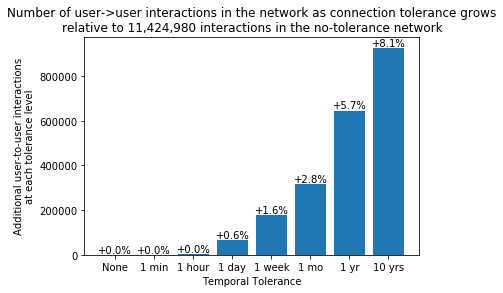

In [17]:
plt.bar(range(len(tolerances)), tolerance_counts - np.min(tolerance_counts))
plt.xticks(range(len(tolerances)), ["None", "1 min", "1 hour", "1 day", "1 week", "1 mo", "1 yr", "10 yrs"])
plt.title(f"Number of user->user interactions in the network as connection tolerance grows\nrelative to {int(tolerance_counts[0]):,} interactions in the no-tolerance network")
plt.xlabel("Temporal Tolerance")
plt.ylabel("Additional user-to-user interactions\nat each tolerance level")
for x, y in zip(range(len(tolerances)), tolerance_counts - np.min(tolerance_counts)):
    pct = y / tolerance_counts[0] * 100
    plt.text(x, y, f'+{pct:.1f}%', horizontalalignment='center', verticalalignment='bottom')
plt.show()

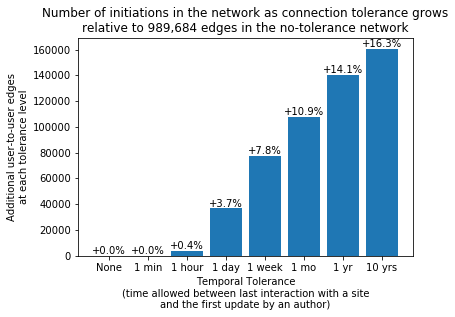

In [18]:
plt.bar(range(len(tolerances)), subset_tolerance_counts - np.min(subset_tolerance_counts))
plt.xticks(range(len(tolerances)), ["None", "1 min", "1 hour", "1 day", "1 week", "1 mo", "1 yr", "10 yrs"])
plt.title(f"Number of initiations in the network as connection tolerance grows\nrelative to {int(subset_tolerance_counts[0]):,} edges in the no-tolerance network")
plt.xlabel("Temporal Tolerance\n(time allowed between last interaction with a site\nand the first update by an author)")
plt.ylabel("Additional user-to-user edges\nat each tolerance level")
for x, y in zip(range(len(tolerances)), subset_tolerance_counts - np.min(subset_tolerance_counts)):
    pct = y / subset_tolerance_counts[0] * 100
    plt.text(x, y, f'+{pct:.1f}%', horizontalalignment='center', verticalalignment='bottom')
plt.show()

### Incorporating both types of threshold

 - Amount of time between interaction and the first update by that author (i.e. the tolerance explored above)
 - Number (or percentage) of updates on a site authored by that author
 
See also: AuthorshipThresholdAnalysis

In [19]:
journal_author_counts = journals.groupby(by=['site_id','user_id']).size()
len(journal_author_counts)

698157

In [20]:
# journal_author_counts is a series with a multi-index
journal_author_counts.head()

site_id  user_id
1        1          187
2        2           29
4        4            1
6        6           17
10       12          15
dtype: int64

In [21]:
# this is the total number of journal updates on each site
site_journal_counts = journals.groupby(by=['site_id']).size()
site_journal_counts.head()

site_id
1     187
2      29
4       1
6      17
10     15
dtype: int64

In [22]:
# ... as a dictionary. key: site_id ->  total number of journal updates on that site
site_journal_counts_dict = site_journal_counts.to_dict()

In [23]:
site_author_counts_dict = defaultdict(dict)
user_site_authorship_percentages = []
for i, tup in tqdm(enumerate(zip(journal_author_counts.index, journal_author_counts)), total=len(journal_author_counts)):
    ind, num_journals = tup
    site_id, user_id = ind
    author_counts_dict = site_author_counts_dict[site_id]
    total_journals = site_journal_counts_dict[site_id]
    percentile = num_journals / total_journals
    user_site_authorship_percentages.append(percentile)
    author_counts_dict[percentile] = user_id

100%|██████████| 698157/698157 [00:02<00:00, 277349.95it/s]


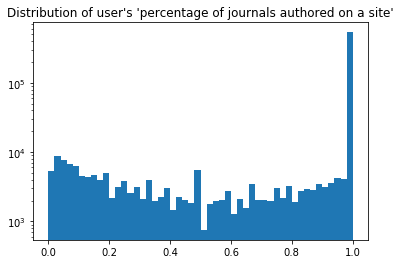

In [23]:
# this plot is a sanity check, showing that the vast majority of users author 100% of the journal updates on a site
plt.hist(user_site_authorship_percentages, bins=50, log=True)
plt.title("Distribution of user's 'percentage of journals authored on a site'")
plt.show()

In [24]:
thresholds = [  # percentile thresholds 
    0,
    0.1,
    0.25,
    0.5,
    0.75,
    0.9,
    1.0
]
threshold_counts = np.zeros((len(thresholds),))

for ind in tqdm(ints.index):
    site_id = site_id_dict[ind]
    created_at = created_at_dict[ind]
    user_id = user_id_dict[ind]
    author_counts_dict = site_author_counts_dict[site_id]
    for percentile_key in author_counts_dict.keys():
        for i, threshold in enumerate(thresholds):
            if percentile_key >= threshold:
                threshold_counts[i] += 1

100%|██████████| 9132345/9132345 [01:20<00:00, 113958.83it/s]


In [25]:
subset_threshold_counts = np.zeros((len(thresholds),))
ints_subset = ints.sort_values(by='created_at', ascending=True).drop_duplicates(subset=['user_id', 'site_id'], keep='first')
for ind in tqdm(ints_subset.index):
    site_id = site_id_dict[ind]
    created_at = created_at_dict[ind]
    user_id = user_id_dict[ind]
    author_counts_dict = site_author_counts_dict[site_id]
    for percentile_key in author_counts_dict.keys():
        for i, threshold in enumerate(thresholds):
            if percentile_key >= threshold:
                subset_threshold_counts[i] += 1

100%|██████████| 914602/914602 [00:09<00:00, 92448.95it/s]


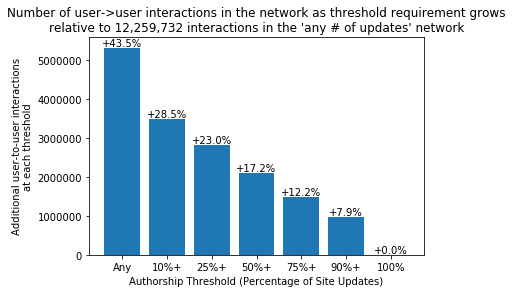

In [26]:
plt.bar(range(len(thresholds)), threshold_counts - np.min(threshold_counts))
plt.xticks(range(len(thresholds)), ["Any", "10%+", "25%+", "50%+", "75%+", "90%+", "100%"])
plt.title(f"Number of user->user interactions in the network as threshold requirement grows\nrelative to {int(threshold_counts[0]):,} interactions in the 'any # of updates' network")
plt.xlabel("Authorship Threshold (Percentage of Site Updates)")
plt.ylabel("Additional user-to-user interactions\nat each threshold")
for x, y in zip(range(len(thresholds)), threshold_counts - np.min(threshold_counts)):
    pct = y / threshold_counts[0] * 100
    plt.text(x, y, f'+{pct:.1f}%', horizontalalignment='center', verticalalignment='bottom')
plt.show()

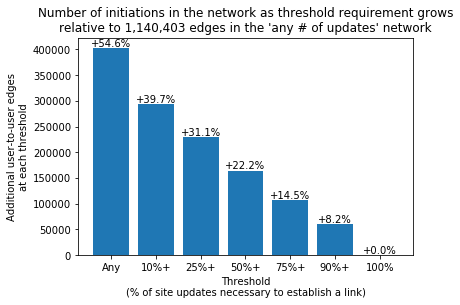

In [27]:
plt.bar(range(len(thresholds)), subset_threshold_counts - np.min(subset_threshold_counts))
plt.xticks(range(len(thresholds)), ["Any", "10%+", "25%+", "50%+", "75%+", "90%+", "100%"])
plt.title(f"Number of initiations in the network as threshold requirement grows\nrelative to {int(subset_threshold_counts[0]):,} edges in the 'any # of updates' network")
plt.xlabel("Threshold\n(% of site updates necessary to establish a link)")
plt.ylabel("Additional user-to-user edges\nat each threshold")
for x, y in zip(range(len(thresholds)), subset_threshold_counts - np.min(subset_threshold_counts)):
    pct = y / subset_threshold_counts[-1] * 100
    plt.text(x, y, f'+{pct:.1f}%', horizontalalignment='center', verticalalignment='bottom')
plt.show()

#### Actually combining both types of threshold

In [28]:
author_info_df = pd.merge(first_author_df, journal_author_counts.rename('num_journals'), left_index=True, right_index=True, validate='one_to_one')

site_author_info_dict = defaultdict(dict)
for i, tup in tqdm(enumerate(zip(author_info_df.index, author_info_df.created_at, author_info_df.num_journals)), total=len(author_info_df)):
    ind, created_at, num_journals = tup
    site_id, user_id = ind
    author_info_dict = site_author_info_dict[site_id]
    total_journals = site_journal_counts_dict[site_id]
    percentile = num_journals / total_journals
    tup_key = (created_at, percentile)
    author_info_dict[tup_key] = user_id

100%|██████████| 698157/698157 [00:07<00:00, 95385.03it/s] 


In [29]:
subset_counts = np.zeros((len(thresholds),len(tolerances)))
ints_subset = ints.sort_values(by='created_at', ascending=True).drop_duplicates(subset=['user_id', 'site_id'], keep='first')
for ind in tqdm(ints_subset.index):
    site_id = site_id_dict[ind]
    created_at = created_at_dict[ind]
    user_id = user_id_dict[ind]
    
    author_info_dict = site_author_info_dict[site_id]
    for created_at_key, percentile_key in author_info_dict.keys():
        for i, threshold in enumerate(thresholds):
            for j, tolerance in enumerate(tolerances):
                if created_at_key <= created_at + tolerance and percentile_key >= threshold:
                    subset_counts[i, j] += 1

100%|██████████| 914602/914602 [01:06<00:00, 13785.59it/s]


In [30]:
subset_counts

array([[ 989687.,  989761.,  993154., 1026279., 1067173., 1097426.,
        1129637., 1150570.],
       [ 933688.,  933757.,  936959.,  967021.,  998633., 1017075.,
        1030354., 1036223.],
       [ 894708.,  894773.,  897780.,  924961.,  949396.,  961000.,
         967802.,  970318.],
       [ 849161.,  849221.,  851989.,  875879.,  893837.,  900517.,
         903063.,  903595.],
       [ 803212.,  803270.,  805789.,  826692.,  839625.,  843266.,
         844367.,  844546.],
       [ 763184.,  763236.,  765595.,  784188.,  794516.,  797036.,
         797803.,  797938.],
       [ 707415.,  707460.,  709574.,  726086.,  734808.,  736967.,
         737674.,  737803.]])

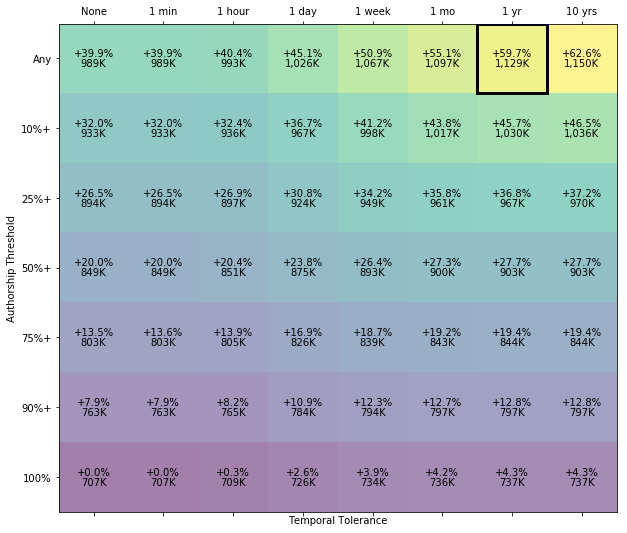

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.matshow(subset_counts - np.min(subset_counts), alpha=0.5)
plt.xticks(range(len(tolerances)), ["None", "1 min", "1 hour", "1 day", "1 week", "1 mo", "1 yr", "10 yrs"])
plt.yticks(range(len(thresholds)), ["Any", "10%+", "25%+", "50%+", "75%+", "90%+", "100%"])
plt.xlabel("Temporal Tolerance")
plt.ylabel("Authorship Threshold")
for i in range(len(thresholds)):
    for j in range(len(tolerances)):
        count = subset_counts[i,j]
        pct = (count - np.min(subset_counts)) / np.min(subset_counts) * 100
        ax.text(j, i, f'+{pct:.1f}%', horizontalalignment='center', verticalalignment='bottom')
        ax.text(j, i, f'{int(count / 1000):,}K', horizontalalignment='center', verticalalignment='top')
rect = patches.Rectangle((6 - 0.5, 0 - 0.5), 1, 1, facecolor='none', edgecolor='black', linewidth=3)
ax.add_patch(rect)
plt.show()

#### Compute patient authors for automatic inclusion

In [24]:
# read the journal metadata with author type info added
s = datetime.now()
author_type_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/author_type"
journal_metadata_filepath = os.path.join(author_type_dir, "journal_metadata_with_author_type.df")
journal_author_type_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_author_type_df)

0:00:23.912896


15850052

In [25]:
# build dictionary of site_id -> set(patient user_ids on this site)
site_patient_author_dict = \
journal_author_type_df[journal_author_type_df.predicted_label == 'p'].groupby('site_id').agg({
    'user_id': lambda user_ids: set(user_ids)
}).user_id.to_dict()
# TODO consider a user_id to be a patient only if they have authored at least TWO patient-authored updates
# right now we consider even a single update to be the interactor
# this is very low priority, since most likely it won't matter very much

## Build the final set of u2u links based on the chosen hyperparameters

In [26]:
u2u = []
#tolerance = 1000 * 60 * 60 * 24 * 365  # 1 year
tolerance = 0  # NO tolerance
for ind in tqdm(ints.index):  # looping through the index is much faster than e.g. iterrows()
    site_id = site_id_dict[ind]
    created_at = created_at_dict[ind]
    user_id = user_id_dict[ind]
    int_type = int_type_dict[ind]
    authors_dict = site_authors_dict[site_id]
    matched_user_set = set()
    for created_at_key in authors_dict.keys():
        if created_at_key <= created_at + tolerance:
            # this is a match!
            target_user_id = authors_dict[created_at_key]
            matched_user_set.add(target_user_id)
            tup = (user_id, target_user_id, created_at, int_type)
            u2u.append(tup)
    if site_id in site_patient_author_dict:
        patient_user_set = site_patient_author_dict[site_id]
        for target_user_id in patient_user_set - matched_user_set:
            # we consider any patient author to be a match
            tup = (user_id, target_user_id, created_at, int_type)
            u2u.append(tup)

100%|██████████| 9132345/9132345 [01:07<00:00, 135477.38it/s]


In [27]:
len(u2u)

14812407

In [28]:
# For comparison, what if we omit the special "patient author" edges?
u2u_count = 0
u2u_subset = []
for ind in tqdm(ints.index):
    site_id = site_id_dict[ind]
    created_at = created_at_dict[ind]
    user_id = user_id_dict[ind]
    int_type = int_type_dict[ind]
    authors_dict = site_authors_dict[site_id]
    for created_at_key in authors_dict.keys():
        if created_at_key <= created_at:
            # this is a match!
            target_user_id = authors_dict[created_at_key]
            u2u_count += 1
            u2u_subset.append((user_id, target_user_id, created_at, int_type))
assert len(u2u_subset) == u2u_count

100%|██████████| 9132345/9132345 [00:50<00:00, 182106.76it/s]


In [29]:
# number of non-patient edges, number of special patient-author edges, percent of all edges that are special
u2u_count, len(u2u) - u2u_count, (len(u2u) - u2u_count) / len(u2u)

(11424980, 3387427, 0.22868849066866714)

In [30]:
u2u_df = pd.DataFrame(u2u, columns=['from_user_id', 'to_user_id', 'created_at', 'int_type'])
unique = u2u_df.drop_duplicates(subset=['from_user_id', 'to_user_id'], keep='first')

In [31]:
u2u_df_nopatient = pd.DataFrame(u2u_subset, columns=['from_user_id', 'to_user_id', 'created_at', 'int_type'])
unique_nopatient = u2u_df_nopatient.drop_duplicates(subset=['from_user_id', 'to_user_id'], keep='first')

In [32]:
len(unique), len(unique_nopatient), len(unique) - len(unique_nopatient)

(1144492, 1088392, 56100)

In [33]:
(len(unique) - len(unique_nopatient)) / len(unique)

0.04901738063699877

In [34]:
# for the revisions, we lock in the initiations dataframe WITHOUT special patient-author edges
# for comparison. This line should be deleted to restore normal functionality.

#u2u = u2u_subset

In [35]:
len(u2u)

14812407

## Reciprocal analysis

In [36]:
u2u_df = pd.DataFrame(u2u, columns=['from_user_id', 'to_user_id', 'created_at', 'int_type'])
len(u2u_df)

14812407

In [37]:
# how many unique edges exist in the graph (at the futuremost possible time times)?
u2u_df.groupby(by=['from_user_id', 'to_user_id']).ngroups

1144492

In [38]:
# in comparison, how many unique edges exist in the graph linking only users to sites i.e. the ints?
ints.groupby(by=['user_id', 'site_id']).ngroups

914602

In [39]:
# as expected, there are fewer user -> site links than there are user -> user links, since multiauthor sites exist

In [40]:
u2u_df

,from_user_id,to_user_id,created_at,int_type
0,1,196238,1141566915000,guestbook
1,2,269744,1146502838000,guestbook
2,2,76800,1141824958000,guestbook
3,2,76800,1141826075000,guestbook
4,2,76800,1144118979000,guestbook
...,...,...,...,...
14812402,33537993,32380464,1502797198000,comment
14812403,33537993,33600838,1502797198000,comment
14812404,33537993,33601773,1502797198000,comment
14812405,33537993,33603282,1502797198000,comment


In [41]:
#how many of these user->user links are reciprocal?
# notice this 'unique' dataframe is another way of determining the number of edges in the graph i.e. it does the same thing as groupby
unique = u2u_df.drop_duplicates(subset=['from_user_id', 'to_user_id'], keep='first')

unique_dict = {(from_user_id, to_user_id): (created_at, int_type) for from_user_id, to_user_id, created_at, int_type in zip(unique.from_user_id, unique.to_user_id, unique.created_at, unique.int_type)}

reciprocal_count = 0
nonreciprocal_count = 0
for key in tqdm(unique_dict.keys()):
    from_user_id, to_user_id = key
    inverse_key = (to_user_id, from_user_id)
    if inverse_key in unique_dict:
        # to avoid double counting, we instead give a "half" count, 
        # so that with the inverse this will be considered a single relationship
        reciprocal_count += 0.5
    else:
        nonreciprocal_count += 1

100%|██████████| 1144492/1144492 [00:02<00:00, 409278.12it/s]


In [42]:
unique = u2u_df.copy()

unique_dict = {(from_user_id, to_user_id, created_at): int_type for from_user_id, to_user_id, created_at, int_type in zip(unique.from_user_id, unique.to_user_id, unique.created_at, unique.int_type)}
user_dict = {(from_user_id, to_user_id): (created_at, int_type) for from_user_id, to_user_id, created_at, int_type in zip(unique.from_user_id, unique.to_user_id, unique.created_at, unique.int_type)}

recips = []
nonrecips = []
for key in tqdm(unique_dict.keys()):
    from_user_id, to_user_id, created_at = key
    inverse_key = (to_user_id, from_user_id)
    if inverse_key in user_dict:
        recips.append((key[0], key[1], key[2], unique_dict[key]))
        # to avoid double counting, we instead give a "half" count, 
        # so that with the inverse this will be considered a single relationship
    else:
        nonrecips.append((key[0], key[1], key[2], unique_dict[key]))

100%|██████████| 10136771/10136771 [00:35<00:00, 283707.62it/s]


In [43]:
reciprocal_count, nonreciprocal_count

(125692.0, 893108)

In [44]:
rec = pd.DataFrame(recips, columns=["from_user_id", "to_user_id", "created_at", "int_type"])
nonrec = pd.DataFrame(nonrecips, columns=["from_user_id", "to_user_id", "created_at", "int_type"])

In [45]:
rec.to_hdf(os.path.join(h5_dir, "recips_nonreduced_inttype.h5"), key="rec")
nonrec.to_hdf(os.path.join(h5_dir, "nonrecips_nonreduced_inttype.h5"), key="nonrec")

In [46]:
int_type = int_type_dict[ind]
print(f"{reciprocal_count / (reciprocal_count + nonreciprocal_count) * 100:.2f}% of dyadic relationships (with at least one edge) are reciprocal.")

12.34% of dyadic relationships (with at least one edge) are reciprocal.


In [47]:
from scipy.special import comb
print(f"{len(unique) / comb(len(set(ints.user_id)), 2) * 100:.4f}% of all possible dyadic relationships exist. (In other words, the interaction network is very sparse.)")

0.0679% of all possible dyadic relationships exist. (In other words, the interaction network is very sparse.)


In [48]:
u2u_df.to_hdf(os.path.join(h5_dir,"revised_u2u.h5"), key="u2u_df")

In [49]:
metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/user_metadata"
u2u_df.to_feather(os.path.join(metadata_dir,"u2u_df.feather"))

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/pyarrow/feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):


In [50]:
# read the user->user interactions dataframe
metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/user_metadata"
u2u_df = pd.read_feather(os.path.join(metadata_dir,"u2u_df.feather"))
len(u2u_df)

14812407

In [51]:
unique = u2u_df.sort_values(by='created_at', ascending=True).drop_duplicates(subset=['from_user_id', 'to_user_id'], keep='first')
len(unique)

1144492

## Network construction

We aim to compute the proportion of initiations over time that are one of the following types of initiation (from Gallagher et al. 2019):

1. Joining Component - An initiation connecting a single author to any weakly-connected subnetwork with more two individuals already connected.
2. Bridging Components - An initiation connecting two components (weakly-connected subnetworks with 2+ authors)
3. Joining Isolates - An initiation that connects two unconnected authors.
4. Intra Component - An initation connecting two individuals who were already both a part of the same network component.


In [52]:
len(set(unique.from_user_id)), len(set(unique.to_user_id))

(207544, 262880)

In [53]:
initiations_df = unique.sort_values(by='created_at', ascending=True)
len(initiations_df)

1144492

In [54]:
user_set = set(unique.from_user_id) | set(unique.to_user_id)
len(user_set)

322223

In [55]:
earliest_timestamp = np.min(initiations_df.created_at)
earliest_date = datetime.utcfromtimestamp(earliest_timestamp / 1000)
earliest_date, earliest_timestamp

(datetime.datetime(2004, 11, 23, 6, 37), 1101191820000)

In [56]:
start_date = datetime.fromisoformat('2005-01-01')
start_timestamp = int(start_date.timestamp() * 1000)
start_date, start_timestamp

(datetime.datetime(2005, 1, 1, 0, 0), 1104559200000)

In [57]:
end_date = datetime.fromisoformat('2016-06-01')
end_timestamp = int(end_date.timestamp() * 1000)
end_date, end_timestamp

(datetime.datetime(2016, 6, 1, 0, 0), 1464757200000)

In [58]:
subset_start_timestamp = datetime.fromisoformat('2014-01-01').timestamp() * 1000
subset_end_timestamp = datetime.fromisoformat('2016-01-01').timestamp() * 1000

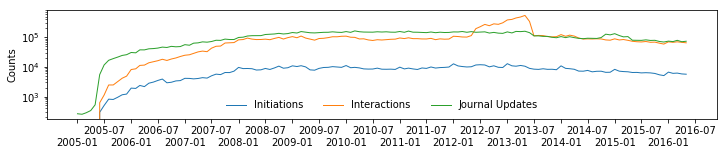

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(12,2))

bins = []
bins.append(start_date.timestamp() * 1000)
year = 2005
month = 1
while year != 2016 or month != 6:
    if month == 12:
        year += 1
        month = 1
    else:
        month += 1
    bins.append(datetime.fromisoformat(f"{year}-{month:02}-01").timestamp() * 1000)

hist, bin_edges = np.histogram(initiations_df.created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Initiations')
#plt.scatter(bin_edges[:-1], hist, color='black', marker='.', s=2)

hist, bin_edges = np.histogram(u2u_df.created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Interactions')
#plt.scatter(bin_edges[:-1], hist, color='black', marker='.', s=2)

hist, bin_edges = np.histogram(journals.created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Journal Updates')
#plt.scatter(bin_edges[:-1], hist, color='black', marker='.', s=2)

plt.legend(ncol=4, frameon=False, loc=8)
plt.yscale('log')
plt.ylabel("Counts")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%Y-%m')}" for i, be in enumerate(xticks)])
plt.show()

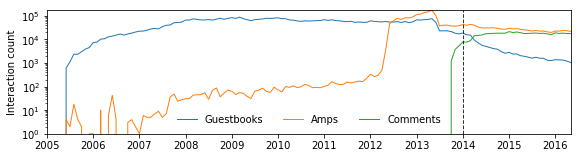

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(8,2)) #5.47807

bins = []
bins.append(start_date.timestamp() * 1000)
year = 2005
month = 1
while year != 2016 or month != 6:
    if month == 12:
        year += 1
        month = 1
    else:
        month += 1
    bins.append(datetime.fromisoformat(f"{year}-{month:02}-01").timestamp() * 1000)

#hist, bin_edges = np.histogram(u2u_df.created_at, bins=bins)
#plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='User->User Interactions')

#hist, bin_edges = np.histogram(ints.created_at, bins=bins)
#plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=2, label='All Interactions')
#plt.scatter(bin_edges[:-1], hist, color='black', marker='.', s=2)

hist, bin_edges = np.histogram(ints[ints.int_type == 'guestbook'].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Guestbooks')

hist, bin_edges = np.histogram(ints[ints.int_type == 'amps'].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Amps')

hist, bin_edges = np.histogram(ints[ints.int_type == 'comment'].created_at, bins=bins)
hist[-34] = 0  # slightly cheating here, but there are 5 test comments before the feature launch that we exclude
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Comments')

plt.axvline(subset_start_timestamp, color='black', alpha=0.8, linestyle='--', linewidth=1)

plt.legend(ncol=4, frameon=False, loc=8)
plt.yscale('log')

#plt.title("Number of author interactions over time")
#plt.xlabel("Date")
plt.ylabel("Interaction count")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i}-01-01").timestamp() * 1000 for i in range((2016 - 2005) + 2)]
#xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{datetime.utcfromtimestamp(be / 1000).strftime('%Y')}" for i, be in enumerate(xticks)])

#xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
#plt.xticks(
#    xticks, 
#    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%Y-%m')}" for i, be in enumerate(xticks)])

plt.tight_layout(pad=0)
plt.margins(0,0)
plt.savefig(os.path.join(figures_dir, 'interaction_counts_over_time.pdf'), dpi=180, pad_inches=0)

plt.show()

In [61]:
# one possible conclusion from the above plots:
# we should probably only be analyzing 2014/01-2016/06! 2.5 years of relative normalacy

#### Amps analysis

In [62]:
# amps analysis
hist, bin_edges = np.histogram(ints[ints.int_type == 'amps'].created_at, bins=bins)
hist

array([     0,      0,      0,      0,      0,      4,      2,     18,
            4,      2,      0,      1,      1,      0,     10,      0,
            6,     43,      4,      0,      0,      3,      4,      2,
            1,      6,      5,      5,      7,      9,      5,      7,
           36,     48,     24,     28,     31,     31,     44,     45,
           46,     55,     29,     70,     88,     37,     53,     72,
           63,     46,     56,     52,     39,     31,     64,     71,
           86,     63,     57,     94,     73,     60,    101,     93,
          108,     91,     99,    124,    111,     90,     93,     90,
          101,    115,    163,    136,    122,    124,    157,    143,
          157,    171,    163,    223,    335,    266,    303,    494,
         3694,  46014,  61604,  79361,  70534,  83062,  81557,  90376,
       114181, 118839, 138376, 147834, 172165, 104104,  37352,  40176,
        40549,  36913,  37039,  38208,  43150,  39794,  43788,  40506,
      

In [63]:
amps_start = datetime.fromisoformat('2012-05-01').timestamp() * 1000
amps_end = datetime.fromisoformat('2012-06-15').timestamp() * 1000
bins = np.linspace(amps_start, amps_end, num=50)
hist, bin_edges = np.histogram(ints[ints.int_type == 'amps'].created_at, bins=bins)

In [64]:
hist

array([  28,   15,   22,   22,   20,   14,   19,   24,   40,   29,   41,
         44,   15,   32,   32,   36,   44,   45,   48,   30,   29,   27,
         48,   57,   62,   74,   97,   41,   55,   51,   90,  239,  430,
       1853, 1406, 1100, 1134, 1167, 1203, 1354, 1133, 1171,  916,  829,
       1143, 1426, 1568, 1347, 1922])

In [65]:
hist[33], datetime.utcfromtimestamp(int(bin_edges[33]) / 1000), datetime.utcfromtimestamp(int(bin_edges[34]) / 1000)

(1853,
 datetime.datetime(2012, 5, 31, 12, 20, 48, 979000),
 datetime.datetime(2012, 6, 1, 10, 23, 15, 918000))

In [66]:
hypothesized_amps_launch = datetime.fromisoformat('2012-06-01').timestamp() * 1000
total_prelaunch_amps = np.sum(ints[ints.int_type == 'amps'].created_at < hypothesized_amps_launch)
total_prelaunch_amps

9612

In [67]:
print(f"Approximately {total_prelaunch_amps / len(ints[ints.int_type == 'amps'])*100:.2f}% of amps occur before the launch of the amps feature.")

Approximately 0.32% of amps occur before the launch of the amps feature.


In [68]:
amps = ints[ints.int_type == 'amps']

In [69]:
week1 = 1000 * 60 * 60 * 24 * 7
week_before_amps_launch = hypothesized_amps_launch - week1
week_after_amps_launch = hypothesized_amps_launch + week1
all_before = np.sum(amps.created_at < week_before_amps_launch)
week_before_amp_count = np.sum((amps.created_at < hypothesized_amps_launch)&(amps.created_at > week_before_amps_launch))
week_after_amp_count = np.sum((amps.created_at > hypothesized_amps_launch)&(amps.created_at < week_after_amps_launch))
all_before, week_before_amp_count, week_after_amp_count
# more amps occurred on updates published in the first week after the feature launch
# than every pre-launch update
# this provides evidence that 

(6823, 2789, 9269)

In [70]:
# in the two weeks around the launch, 23% of the amps occurred before the launch
week_before_amp_count / (week_before_amp_count + week_after_amp_count)

0.23129872283960856

### Build and classify network initiations



In [71]:
# This graph implementation tracks only weakly-connected components, and doesn't specifically keep track
# of edges.

class Graph:
    def __init__(self, node_uids):
        self.node_uids = node_uids
        self.node_dict = {}  # maps node_uid to component_uid
        self.component_dict = {}  # maps component_uid to a set of node_uids
        for component_uid, node_uid in enumerate(self.node_uids):
            self.node_dict[node_uid] = component_uid
            self.component_dict[component_uid] = set((node_uid,))
        self.edge_count = 0
        
        self.largest_wcc_size = 0
        
    def add_edge(self, from_node_uid, to_node_uid):
        self.edge_count += 1
        from_component_uid = self.node_dict[from_node_uid]
        to_component_uid = self.node_dict[to_node_uid]
        if from_component_uid == to_component_uid:
            # these nodes are already weakly connected
            is_intra_component_edge = True
            new_component_size = len(self.component_dict[from_component_uid])
            from_component_size, to_component_size = new_component_size, new_component_size
        else:  # two different components are being merged with this edge
            is_intra_component_edge = False
            from_component_nodes = self.component_dict[from_component_uid]
            to_component_nodes = self.component_dict[to_component_uid]
            from_component_size = len(from_component_nodes)
            to_component_size = len(to_component_nodes)
            
            if from_component_size >= to_component_size:
                # merge To component into From component, deleting the To component
                from_component_nodes.update(to_component_nodes)
                del self.component_dict[to_component_uid]
                for node_uid in to_component_nodes:
                    # update the merged in component ids
                    self.node_dict[node_uid] = from_component_uid
                new_component_size = len(from_component_nodes)
            else:
                # merge From component into To component, deleting the From component
                to_component_nodes.update(from_component_nodes)
                del self.component_dict[from_component_uid]
                for node_uid in from_component_nodes:
                    # update the merged in component ids
                    self.node_dict[node_uid] = to_component_uid
                new_component_size = len(to_component_nodes)
            if new_component_size > self.largest_wcc_size:
                self.largest_wcc_size = new_component_size
        # new_component_size gives the size of the resulting component
        return is_intra_component_edge, from_component_size, to_component_size, new_component_size
    
    def get_component_info(self):
        num_wccs = len(self.component_dict)
        #largest_wcc_size = max(self.component_dict.values())
        return num_wccs, self.largest_wcc_size

In [72]:
initiation_type_labels = []
joining_component_directionality = []
wcc_info = []
involves_largest_wcc_list = []
g = Graph(user_set)
for from_user_id, to_user_id in tqdm(zip(initiations_df.from_user_id, initiations_df.to_user_id), total=len(initiations_df)):
    is_intra_component_edge, from_component_size, to_component_size, new_component_size = g.add_edge(from_user_id, to_user_id)
    num_wccs, largest_wcc_size = g.get_component_info()
    wcc_info.append((num_wccs, largest_wcc_size))
    # if the new component has the same size as the LWCC, it 'involves' the LWCC
    involves_largest_wcc_list.append(largest_wcc_size == new_component_size)
    label = 0
    if is_intra_component_edge:
        label = 4  # intra component
    else:  # these two users were not previously connected
        if from_component_size <= 1:
            if to_component_size <= 1:
                label = 3  # joining isolates
            else:
                label = 1  # joining component
                is_isolate_initiating_join = True
                joining_component_directionality.append(is_isolate_initiating_join)
        else:  # from_user is already in a component
            if to_component_size <= 1:
                label = 1  # joining component
                is_isolate_initiating_join = False
                joining_component_directionality.append(is_isolate_initiating_join)
            else:
                label = 2  # bridging components
    initiation_type_labels.append(label)

100%|██████████| 1144492/1144492 [00:09<00:00, 126780.48it/s]


In [73]:
num_wccs, largest_wcc_size = wcc_info[-1]
print(f"After processing all initiations, there were {num_wccs} WCCs, with the largest containing {largest_wcc_size} users.")

After processing all initiations, there were 6366 WCCs, with the largest containing 306065 users.


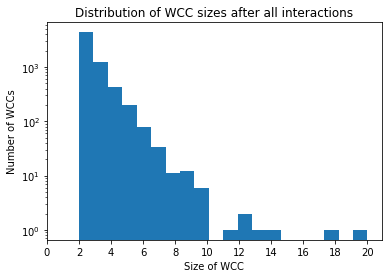

In [74]:
# sizes of all WCCs, EXCEPT the largest
wcc_sizes = np.array(sorted([len(s) for s in g.component_dict.values()])[:-1])
plt.hist(wcc_sizes, bins=20, log=True)
plt.xticks(range(0,22,2))
plt.xlabel("Size of WCC")
plt.ylabel("Number of WCCs")
plt.title("Distribution of WCC sizes after all interactions")
plt.show()

In [75]:
pct = np.sum(joining_component_directionality) / len(joining_component_directionality)
print(f"{pct*100:.2f}% of Joining Component initiations are initiated by the isolate (and not someone in the component).")

41.30% of Joining Component initiations are initiated by the isolate (and not someone in the component).


In [76]:
# This compared my implementation to the NetworkX implementation
#np.sum(np.array(initiation_type_labels[:len(initiation_labels)]) == np.array(initiation_labels)) / len(initiation_labels)

In [77]:
# This approach uses NetworkX
# It is too slow to be tractable; computing the first 20% took 13 hours, with an estimate of 100 hours remaining
should_run = False
if should_run:
    G = nx.Graph()
    nodes = sorted(list(user_set))
    G.add_nodes_from(nodes)
    len(G)

    initiation_labels = []
    for from_user_id, to_user_id in tqdm(zip(initiations_df.from_user_id, initiations_df.to_user_id), total=len(initiations_df)):
        from_component = nx.node_connected_component(G, from_user_id)
        to_component = nx.node_connected_component(G, to_user_id)
        label = 0
        if from_user_id in to_component or to_user_id in from_component:
            label = 4  # intra component
        else:  # these two users were not previously connected
            if len(from_component) <= 1:
                if len(to_component) <= 1:
                    label = 3  # joining isolates
                else:
                    label = 1  # joining component
            else:  # from_user is already in a component
                if len(to_component) <= 1:
                    label = 1  # joining component
                else:
                    label = 2  # bridging components
        initiation_labels.append(label)
        G.add_edge(from_user_id, to_user_id)

In [78]:
Counter(initiation_type_labels).most_common()

[(4, 828635), (1, 244425), (3, 38899), (2, 32533)]

In [79]:
initiations_df.head()

,from_user_id,to_user_id,created_at,int_type
13689525,23616609,20085865,1101191820000,amps
10935800,10499159,20085865,1101191820000,amps
2789662,1217109,1,1103856900000,amps
8914,122,48,1117645589000,guestbook
9348,193,48,1117656613000,guestbook


In [80]:
initiations_df['initiation_type'] = initiation_type_labels

In [81]:
initiations_df['is_isolate_initiating_join'] = np.nan
initiations_df.loc[initiations_df.initiation_type == 1, 'is_isolate_initiating_join'] = joining_component_directionality

In [82]:
is_reciprocal_list = []
initiations_set = set()
for from_user_id, to_user_id in tqdm(zip(initiations_df.from_user_id, initiations_df.to_user_id), total=len(initiations_df)):
    key = (from_user_id, to_user_id)
    assert key not in initiations_set
    inverse_key = (to_user_id, from_user_id)
    if inverse_key in initiations_set:
        is_reciprocal = True
    else:
        is_reciprocal = False
    initiations_set.add(key)
    is_reciprocal_list.append(is_reciprocal)
    
initiations_df['is_reciprocal'] = is_reciprocal_list

100%|██████████| 1144492/1144492 [00:03<00:00, 290254.82it/s]


In [83]:
# confirm that all reciprocal initiations are considered intra-component initiations
assert np.all(initiations_df[initiations_df.is_reciprocal].initiation_type == 4)

In [84]:
initiations_df['involves_lwcc'] = involves_largest_wcc_list

In [85]:
subset_start_timestamp = datetime.fromisoformat('2014-01-01').timestamp() * 1000
subset_df = initiations_df[(initiations_df.created_at < end_timestamp)&(initiations_df.created_at > subset_start_timestamp)]
pct = len(subset_df[(subset_df.initiation_type == 2)|(subset_df.initiation_type == 3)]) / len(subset_df)
print(f"{pct*100:.2f}% of initiations from 2014/01 to 2016/06 bridge two components or join two isolated components.")

3.62% of initiations from 2014/01 to 2016/06 bridge two components or join two isolated components.


In [86]:
# these are the analysis period counts for each of the initiation types
init_type_dict = {
    1: 'Joining Component',
    2: 'Bridging Components',
    3: 'Joining Isolates', 
    4: 'Intra Component'
}
for init_type, count in Counter(subset_df.initiation_type).most_common():
    print(f"{init_type_dict[init_type]:>20} {count:>8}  {count / len(subset_df) * 100:>8.2f}%")

     Intra Component   155996     77.54%
   Joining Component    37905     18.84%
 Bridging Components     3761      1.87%
    Joining Isolates     3526      1.75%


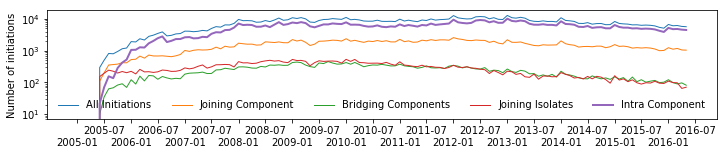

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(12,2))

bins = []
bins.append(start_date.timestamp() * 1000)
year = 2005
month = 1
while year != 2016 or month != 6:
    if month == 12:
        year += 1
        month = 1
    else:
        month += 1
    bins.append(datetime.fromisoformat(f"{year}-{month:02}-01").timestamp() * 1000)

#hist, bin_edges = np.histogram(ints.created_at, bins=bins)
#plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='User->Site Interactions')
#plt.scatter(bin_edges[:-1], hist, color='black', marker='.', s=2)

hist, bin_edges = np.histogram(initiations_df.created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='All Initiations')

hist, bin_edges = np.histogram(initiations_df[initiations_df.initiation_type == 1].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Joining Component')

hist, bin_edges = np.histogram(initiations_df[initiations_df.initiation_type == 2].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Bridging Components')

hist, bin_edges = np.histogram(initiations_df[initiations_df.initiation_type == 3].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Joining Isolates')

hist, bin_edges = np.histogram(initiations_df[initiations_df.initiation_type == 4].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=2, label='Intra Component')


plt.legend(ncol=5, frameon=False, loc=8)
plt.yscale('log')

#plt.xlabel("Date")
plt.ylabel("Number of initiations")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%Y-%m')}" for i, be in enumerate(xticks)])
plt.show()

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


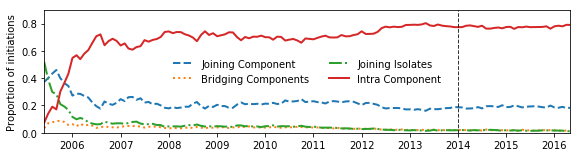

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(8,2))

bins = []
bins.append(start_date.timestamp() * 1000)
year = 2005
month = 1
while year != 2016 or month != 6:
    if month == 12:
        year += 1
        month = 1
    else:
        month += 1
    bins.append(datetime.fromisoformat(f"{year}-{month:02}-01").timestamp() * 1000)

total_initiation_counts, bin_edges = np.histogram(initiations_df.created_at, bins=bins)

hist, bin_edges = np.histogram(initiations_df[initiations_df.initiation_type == 1].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist / total_initiation_counts, linestyle='dashed', linewidth=2, label='Joining Component')

hist, bin_edges = np.histogram(initiations_df[initiations_df.initiation_type == 2].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist / total_initiation_counts, linestyle='dotted', linewidth=2, label='Bridging Components')

hist, bin_edges = np.histogram(initiations_df[initiations_df.initiation_type == 3].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist / total_initiation_counts, linestyle='dashdot', linewidth=2, label='Joining Isolates')

hist, bin_edges = np.histogram(initiations_df[initiations_df.initiation_type == 4].created_at, bins=bins)
plt.plot(bin_edges[:-1], hist / total_initiation_counts, linestyle='-', linewidth=2, label='Intra Component')

#hist, bin_edges = np.histogram(initiations_df[(initiations_df.initiation_type == 4)&(~initiations_df.is_reciprocal)].created_at, bins=bins)
#plt.plot(bin_edges[:-1], hist / total_initiation_counts, linestyle='-', linewidth=2, label='Intra Component (Other)')

#hist, bin_edges = np.histogram(initiations_df[(initiations_df.initiation_type == 4)&(initiations_df.is_reciprocal)].created_at, bins=bins)
#plt.plot(bin_edges[:-1], hist / total_initiation_counts, linestyle='-', linewidth=2, label='Intra Component (Direct Reciprocation)')

plt.axvline(subset_start_timestamp, color='black', alpha=0.8, linestyle='--', linewidth=1)

plt.legend(ncol=2, frameon=False, loc=10)
#plt.legend(ncol=3, frameon=False, loc=9)
plt.ylim((0,0.9))
#plt.yscale('log')

#plt.title("Initiation Type")
#plt.xlabel("Date")
plt.ylabel("Proportion of initiations")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i}-01-01").timestamp() * 1000 for i in range((2016 - 2005) + 2)]
#xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{datetime.utcfromtimestamp(be / 1000).strftime('%Y')}" for i, be in enumerate(xticks)])
#    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%m %Y')}" for i, be in enumerate(xticks)])

     
plt.tight_layout(pad=0)
plt.margins(0,0)
plt.savefig(os.path.join(figures_dir, 'initiation_types_timeline.pdf'), dpi=200, pad_inches=0)
     
plt.show()

In [89]:
subset_start_timestamp = datetime.fromisoformat('2014-01-01').timestamp() * 1000
subset_df = initiations_df[(initiations_df.created_at < end_timestamp)&(initiations_df.created_at > subset_start_timestamp)]
total_pct = len(subset_df[(subset_df.initiation_type == 4)&(subset_df.is_reciprocal)]) / len(subset_df)
intra_component_pct = len(subset_df[(subset_df.initiation_type == 4)&(subset_df.is_reciprocal)]) / len(subset_df[subset_df.initiation_type == 4])
print(f"{total_pct*100:.2f}% of initiations from 2014/01 to 2016/06 are reciprocal, which is {intra_component_pct*100:.2f}% of the Intra Component initiations.")

10.79% of initiations from 2014/01 to 2016/06 are reciprocal, which is 13.91% of the Intra Component initiations.


#### Largest WCC analysis

Vast majority of interactions involved the largest WCC

In [90]:
subset_df = initiations_df[(initiations_df.created_at < end_timestamp)&(initiations_df.created_at > subset_start_timestamp)]
len(subset_df)

201188

In [91]:
np.sum(subset_df.involves_lwcc) / len(subset_df)

0.9645953038948645

In [92]:
for i in [1, 2, 3, 4]:
    pct_of_type = np.sum(subset_df[subset_df.initiation_type == i].involves_lwcc) / len(subset_df[subset_df.initiation_type == i])
    print(f"{init_type_dict[i]:>20} {pct_of_type * 100:.2f}%")

   Joining Component 93.37%
 Bridging Components 96.14%
    Joining Isolates 0.00%
     Intra Component 99.40%


#### Joining Isolates

In [93]:
subset_start_timestamp = datetime.fromisoformat('2014-01-01').timestamp() * 1000
subset_df = initiations_df[(initiations_df.created_at < end_timestamp)&(initiations_df.created_at > subset_start_timestamp)]
pct = len(subset_df[(subset_df.initiation_type == 1)&(subset_df.is_isolate_initiating_join)]) / len(subset_df[subset_df.initiation_type == 1])
#intra_component_pct = len(subset_df[(subset_df.initiation_type == 4)&(subset_df.is_reciprocal)]) / len(subset_df[subset_df.initiation_type == 4])
print(f"{pct*100:.2f}% of Joining Component initiations from 2014/01 to 2016/06 are initiated by the isolate, meaning {(1 - pct)*100:.2f}% are initiated by an author already in a component.")

24.08% of Joining Component initiations from 2014/01 to 2016/06 are initiated by the isolate, meaning 75.92% are initiated by an author already in a component.


In [94]:
joining_isolates = subset_df[
    (subset_df.initiation_type == 1)
    &(subset_df.is_isolate_initiating_join)
    &(subset_df.from_user_id.isin(valid_user_ids))
    &(subset_df.to_user_id.isin(valid_user_ids))
]
len(joining_isolates)

8687

In [95]:
sample = joining_isolates[joining_isolates.int_type == 'guestbook'].sample(n=100)
sample.head()

,from_user_id,to_user_id,created_at,int_type,initiation_type,is_isolate_initiating_join,is_reciprocal,involves_lwcc
14477782,28732788,28728957,1401112007000,guestbook,1,True,False,True
13329951,21895557,13608152,1435227860000,guestbook,1,True,False,True
14554915,29528635,17279784,1458046376000,guestbook,1,True,False,True
14469591,28658592,13174926,1399665610000,guestbook,1,True,False,True
11461933,13079902,2022616,1411074709000,guestbook,1,True,False,True


In [96]:
should_run = False  # already generated this sample
if should_run:
    sample_filepath = os.path.join(working_dir, 'isolate_joining_component_100.csv')
    sample[['from_user_id', 'to_user_id', 'created_at', 'involves_lwcc']].to_csv(sample_filepath, index=False)
    sample_filepath

### Save initiations_df

In [48]:
initiations_df_filepath = os.path.join(working_dir, "init_df.feather")
initiations_df.reset_index(drop=True).to_feather(initiations_df_filepath)
print("Finished.")

Finished.


### Reciprocation


In [190]:
subset_df = initiations_df[(initiations_df.created_at < end_timestamp)&(initiations_df.created_at > subset_start_timestamp)]
subset_df.head()

,from_user_id,to_user_id,created_at,int_type,initiation_type,is_isolate_initiating_join,is_reciprocal,involves_lwcc
10216334,22239537,5758186,1388556151000,amps,4,NaN,False,True
6003872,5135645,5758186,1388556151000,amps,4,NaN,False,True
9221217,15878504,5758186,1388556151000,amps,4,NaN,False,True
8748699,13274610,3761912,1388556206000,amps,4,NaN,False,True
9902161,20146227,3761912,1388556206000,amps,4,NaN,False,True


In [191]:
len(subset_df)  # 200K initations in the analysis period

194829

In [192]:
np.sum(subset_df.is_reciprocal) / len(subset_df), np.sum(subset_df.is_reciprocal), len(subset_df)

(0.10985530901457176, 21403, 194829)

In [193]:
# Of ALL dyads, 12.3\% are reciprocated
total_dyads = 0
reciprocated_dyads = 0
seen_pairs = set()
for row in tqdm(initiations_df.itertuples(), total=len(initiations_df)):
    tup = (row.from_user_id, row.to_user_id)
    r_tup = (row.to_user_id, row.from_user_id)
    if r_tup not in seen_pairs:
        total_dyads += 1
        seen_pairs.add(tup)
    if row.is_reciprocal:
        reciprocated_dyads += 1
reciprocated_dyads / total_dyads

100%|██████████| 1088392/1088392 [00:03<00:00, 311741.46it/s]


0.12810583791806765

In [194]:
reciprocated_dyads, total_dyads

(123596, 964796)

In [195]:
# Of dyads that begin in the analysis period, 6.5\% are reciprocated
# TODO Should really update this to only be marked reciprocal if the reciprocation happened within some time window
subset_df = initiations_df[
        (initiations_df.created_at < end_timestamp)
        &(initiations_df.created_at > start_timestamp)
        &(initiations_df.from_user_id.isin(valid_user_ids))
        &(initiations_df.to_user_id.isin(valid_user_ids))
    ].sort_values(by=['created_at', 'is_reciprocal'], ascending=True)
total_dyads = 0
reciprocated_dyads = 0
unreciprocated_dyads_set = set()
reciprocated_dyads_list = []
reciprocation_interval_list = []
seen_pairs = {}
for row in tqdm(subset_df.itertuples(), total=len(subset_df)):
    tup = (row.from_user_id, row.to_user_id)
    r_tup = (row.to_user_id, row.from_user_id)
    if not row.is_reciprocal:
        assert r_tup not in seen_pairs
        total_dyads += 1
        seen_pairs[tup] = row.created_at
        unreciprocated_dyads_set.add(tup)
    elif r_tup in seen_pairs and row.is_reciprocal:
        reciprocated_dyads += 1
        unreciprocated_dyads_set.remove(r_tup)
        reciprocated_dyads_list.append(r_tup)
        initiation_created_at = seen_pairs[r_tup]
        reciprocation_interval = row.created_at - initiation_created_at
        assert reciprocation_interval > 0
        reciprocation_interval_list.append(reciprocation_interval)
reciprocated_dyads / total_dyads

100%|██████████| 902145/902145 [00:03<00:00, 255294.67it/s]


0.15317211970610342

In [196]:
reciprocated_dyads, total_dyads

(119829, 782316)

In [197]:
len(reciprocated_dyads_list), len(unreciprocated_dyads_set)

(119829, 662487)

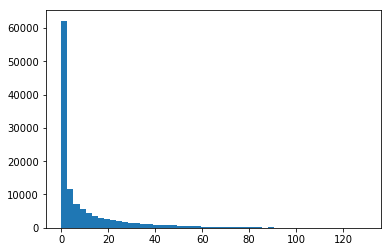

74.20141979938272

In [198]:
recip_interval_months = np.array(reciprocation_interval_list) / 1000 / 60 / 60 / 24 / 30
plt.hist(recip_interval_months, bins=50)
plt.show()
np.quantile(recip_interval_months, 0.99)

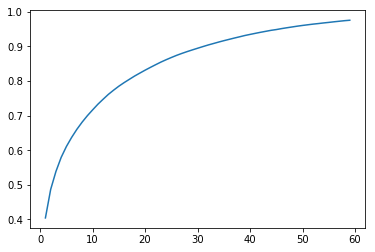

0.7474234116949987

In [199]:
# percentage of reciprocations that occur within X months
xs = range(1, 12 * 5)
ys = []
for i in xs:
    pct_reciprocated_by_month = np.sum(recip_interval_months <= i) / len(recip_interval_months)
    ys.append(pct_reciprocated_by_month)
plt.plot(xs, ys)
plt.show()
np.sum(recip_interval_months <= 12) / len(recip_interval_months)

In [200]:
recip_interval_days = np.array(reciprocation_interval_list) / 1000 / 60 / 60 / 24
np.sum(recip_interval_days <= 365) / len(recip_interval_days)

0.7498852531524088

In [201]:
threshold = 1000 * 60 * 60 * 24 * 365 # 365 days
subset_df = initiations_df[
        (initiations_df.created_at < end_timestamp)
        &(initiations_df.created_at > start_timestamp)
        &(initiations_df.from_user_id.isin(valid_user_ids))
        &(initiations_df.to_user_id.isin(valid_user_ids))
    ].sort_values(by=['created_at', 'is_reciprocal'], ascending=True)
total_dyads = 0
reciprocated_dyads = 0
unreciprocated_dyads_set = set()
reciprocated_dyads_list = []
reciprocation_interval_list = []
seen_pairs = {}
for row in tqdm(subset_df.itertuples(), total=len(subset_df)):
    tup = (row.from_user_id, row.to_user_id)
    r_tup = (row.to_user_id, row.from_user_id)
    if not row.is_reciprocal:
        assert r_tup not in seen_pairs
        if row.created_at > end_timestamp - threshold:
            continue  # ignore all initiations that could have right-censored initiations
        total_dyads += 1
        seen_pairs[tup] = row.created_at
        unreciprocated_dyads_set.add(tup)
    elif r_tup in seen_pairs and row.is_reciprocal:
        initiation_created_at = seen_pairs[r_tup]
        reciprocation_interval = row.created_at - initiation_created_at
        assert reciprocation_interval > 0
        if reciprocation_interval <= threshold:
            # this was a reciprocation that occurred within 1 year!
            reciprocated_dyads += 1
            unreciprocated_dyads_set.remove(r_tup)
            reciprocated_dyads_list.append(r_tup)
            reciprocation_interval_list.append(reciprocation_interval)
        # else we pretend as though the dyad was just not reciprocated (which it wasn't, within the threshold)
reciprocated_dyads / total_dyads

100%|██████████| 902145/902145 [00:03<00:00, 243263.99it/s]


0.12043935553097528

In [202]:
reciprocated_dyads

87326

In [203]:
# read the user author type dataframe
author_type_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/author_type"
user_patient_proportions_filepath = os.path.join(author_type_dir, 'user_patient_proportions.df')
user_df = pd.read_feather(user_patient_proportions_filepath)
len(user_df)

362345

In [204]:
author_type_dict = {row.user_id: row.user_author_type for row in user_df.itertuples()}

In [205]:
d = []
for dyad in reciprocated_dyads_list:
    from_user_id, to_user_id = dyad
    from_author_type = author_type_dict[from_user_id]
    to_author_type = author_type_dict[to_user_id]
    d.append({
        'from_user_id': from_user_id,
        'to_user_id': to_user_id,
        'is_reciprocated': 1,
        'is_author_type_shared': int(from_author_type == to_author_type),
        'from_author_type': from_author_type,
        'to_author_type': to_author_type,
        'original_initiation_time': seen_pairs[dyad]
    })
for dyad in unreciprocated_dyads_set:
    from_user_id, to_user_id = dyad
    from_author_type = author_type_dict[from_user_id]
    to_author_type = author_type_dict[to_user_id]
    d.append({
        'from_user_id': from_user_id,
        'to_user_id': to_user_id,
        'is_reciprocated': 0,
        'is_author_type_shared': int(from_author_type == to_author_type),
        'from_author_type': from_author_type,
        'to_author_type': to_author_type,
        'original_initiation_time': seen_pairs[dyad]
    })
dyad_df = pd.DataFrame(d)
len(dyad_df)

725062

#### Merge in author activity features

In [206]:
recip_user_ids = set(dyad_df.from_user_id) | set(dyad_df.to_user_id)
journals_subset = journals[journals.user_id.isin(recip_user_ids)]
len(journals_subset), len(journals_subset) / len(journals)

(11906341, 0.7278691120232819)

In [207]:
print(len(dyad_df))
dyad_df.head()

725062


,from_user_id,to_user_id,is_reciprocated,is_author_type_shared,from_author_type,to_author_type,original_initiation_time
0,248,33,1,1,cg,cg,1117754812000
1,28,8339,1,1,cg,cg,1119235827000
2,5103,8468,1,1,cg,cg,1119010597000
3,3079,4622,1,1,cg,cg,1119066341000
4,8175,28,1,0,p,cg,1119238748000


In [208]:
first_updates = journals_subset.sort_values(by='created_at', ascending=True).drop_duplicates(subset='user_id')
first_updates_dict = {row.user_id: row.created_at for row in first_updates.itertuples()}

In [209]:
dyad_df['was_initiator_author'] = [int(row.original_initiation_time >= first_updates_dict[row.from_user_id]) for row in dyad_df.itertuples()]
np.sum(dyad_df.was_initiator_author) / len(dyad_df)

0.6886128358678293

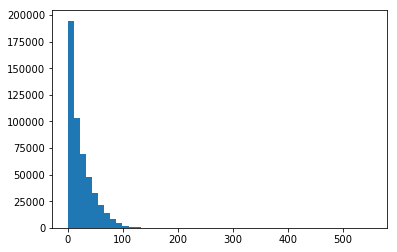

In [210]:
dyad_df['months_after_initiator_authorship'] = [np.clip(row.original_initiation_time - first_updates_dict[row.from_user_id], 0, None) / (1000 * 60 * 60 * 24 * 30)
                                                for row in dyad_df.itertuples()]
plt.hist(dyad_df[dyad_df.was_initiator_author == 1].months_after_initiator_authorship, bins=50)
plt.show()

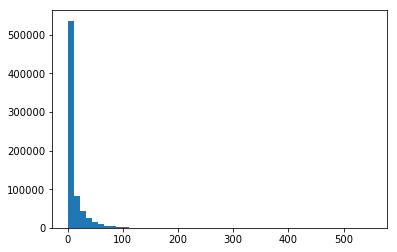

In [211]:
dyad_df['months_after_receiver_authorship'] = [np.clip(row.original_initiation_time - first_updates_dict[row.to_user_id], 0, None) / (1000 * 60 * 60 * 24 * 30)
                                                for row in dyad_df.itertuples()]
#assert np.all(dyad_df.months_after_receiver_authorship >= 0)
# the assertion fails because of patient authors who were treated as connection targets but had not yet published any updates!
plt.hist(dyad_df.months_after_receiver_authorship, bins=50)
plt.show()

In [212]:
def censored_log(value):
    if value == 0:
        return 0
    else:
        assert value > 0, value
        return np.log(value)

In [213]:
dyad_df['log_months_after_initiator_authorship'] = dyad_df.months_after_initiator_authorship.map(censored_log)
dyad_df['log_months_after_receiver_authorship'] = dyad_df.months_after_receiver_authorship.map(censored_log)

In [214]:
# TODO given the length of dyad_df, why is 725062 above and 737747 below
# and why is neither of those counts 
len(dyad_df)

725062

In [215]:
np.sum(dyad_df.is_reciprocated), np.sum(dyad_df.is_reciprocated) / len(dyad_df)

(87326, 0.12043935553097528)

### Fit logistic regression models to predict reciprocation

In [216]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [217]:
def print_feature_summary(res):
    for feature, coef in zip(res.params.index, res.params):
        prob = np.exp(coef)/(1+np.exp(coef))
        feature_name = feature
        if "health_condition" in feature_name:
            feature_name = "health_condition " + feature_name.split("[")[1][2:-1]
        print(f"{feature_name:<50} {min((np.exp(coef)-1)*100, 999):>8.3f}% increase   {prob*100:>8.2f}%   ({np.exp(coef):.3f})")

In [218]:
formula = """
is_reciprocated ~ 
    + is_author_type_shared
    + was_initiator_author
    + was_initiator_author : log_months_after_initiator_authorship
    + log_months_after_receiver_authorship
    + 1
"""
# + num_sites OR is_multisite_author
# + health_condition
model = smf.logit(formula=formula, 
                  data=dyad_df)
res = model.fit(maxiter=100)
print_feature_summary(res)
res.summary()

Optimization terminated successfully.
         Current function value: 0.351113
         Iterations 6
Intercept                                           -91.607% increase       7.74%   (0.084)
is_author_type_shared                                21.941% increase      54.94%   (1.219)
was_initiator_author                                215.771% increase      75.95%   (3.158)
was_initiator_author:log_months_after_initiator_authorship  -27.152% increase      42.15%   (0.728)
log_months_after_receiver_authorship                  3.425% increase      50.84%   (1.034)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        is_reciprocated   No. Observations:               725062
Model:                          Logit   Df Residuals:                   725057
Method:                           MLE   Df Model:                            4
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                 0.04537
Time:                        10:53:25   Log-Likelihood:            -2.5458e+05
converged:                       True   LL-Null:                   -2.6668e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -2.4778      0.009   -264.107      0.000      -2.496      -2.459
is_author_type_shared                                          0.1984      0.008     24.501      0.000       0.182       0.214
was_initiator_author                                           1.1498      0.010    116.704      0.000       1.131       1.169
was_initiator_author:log_months_after_initiator_authorship    -0.3168      0.002   -137.500      0.000      -0.321      -0.312
log_months_after_receiver_authorship                           0.0337      0.001     22.857      0.000       0.031       0.037
==============================================================================================================================
"""

In [219]:
formula = """
is_reciprocated ~ 
    + from_author_type
    + to_author_type
    + from_author_type : to_author_type
    + was_initiator_author
    + was_initiator_author : log_months_after_initiator_authorship
    + log_months_after_receiver_authorship
    + 1
"""
# + num_sites OR is_multisite_author
# + health_condition
model = smf.logit(formula=formula, 
                  data=dyad_df)
res = model.fit(maxiter=100)
print_feature_summary(res)
res.summary()

Optimization terminated successfully.
         Current function value: 0.349177
         Iterations 6
Intercept                                           -90.342% increase       8.81%   (0.097)
from_author_type[T.mixed]                            -8.673% increase      47.73%   (0.913)
from_author_type[T.p]                               -28.443% increase      41.71%   (0.716)
to_author_type[T.mixed]                             -14.843% increase      45.99%   (0.852)
to_author_type[T.p]                                  -9.135% increase      47.61%   (0.909)
from_author_type[T.mixed]:to_author_type[T.mixed]    82.845% increase      64.64%   (1.828)
from_author_type[T.p]:to_author_type[T.mixed]        95.597% increase      66.17%   (1.956)
from_author_type[T.mixed]:to_author_type[T.p]        88.628% increase      65.35%   (1.886)
from_author_type[T.p]:to_author_type[T.p]           231.083% increase      76.80%   (3.311)
was_initiator_author                                214.766% increase 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        is_reciprocated   No. Observations:               725062
Model:                          Logit   Df Residuals:                   725050
Method:                           MLE   Df Model:                           11
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                 0.05063
Time:                        10:53:36   Log-Likelihood:            -2.5318e+05
converged:                       True   LL-Null:                   -2.6668e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     -2.3374      0.008   -289.153      0.000      -2.353      -2.322
from_author_type[T.mixed]                                     -0.0907      0.016     -5.566      0.000      -0.123      -0.059
from_author_type[T.p]                                         -0.3347      0.013    -24.919      0.000      -0.361      -0.308
to_author_type[T.mixed]                                       -0.1607      0.017     -9.363      0.000      -0.194      -0.127
to_author_type[T.p]                                           -0.0958      0.015     -6.478      0.000      -0.125      -0.067
from_author_type[T.mixed]:to_author_type[T.mixed]              0.6035      0.044     13.775      0.000       0.518       0.689
from_author_type[T.p]:to_author_type[T.mixed]                  0.6709      0.035     19.236      0.000       0.603       0.739
from_author_type[T.mixed]:to_author_type[T.p]                  0.6346      0.037     17.306      0.000       0.563       0.706
from_author_type[T.p]:to_author_type[T.p]                      1.1972      0.025     48.187      0.000       1.149       1.246
was_initiator_author                                           1.1467      0.010    115.967      0.000       1.127       1.166
was_initiator_author:log_months_after_initiator_authorship    -0.3140      0.002   -135.618      0.000      -0.319      -0.309
log_months_after_receiver_authorship                           0.0349      0.001     23.533      0.000       0.032       0.038
==============================================================================================================================
"""

In [220]:
# for a patient/patient dyad relative to a caregiver/caregiver dyad,
# given the original author initiated 6 months after authorship and the receiver received 6 months after authorship
# reciprocation is 300% more likely. Seems high!
(np.exp(-0.3319 - 0.1101 + 1.2045 + 0.0365 * np.log(6) +  1.1151 - 0.3101 * np.log(6)) - 1) * 100

300.43233271097785

In [221]:
# https://stats.idre.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/
b = res.params
# when from_p is 0, means the initiator is a CG; when 1, means initiator is a P
# These are the probabilities of reciprocation when the the categorical variables are the given values
# e.g. 7.2% prob of reciprocation when the initiator is a CG and the receiver is a P.
recip_probs = np.zeros((2, 2))
for from_p, to_p in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    Xb = b[0] + from_p * b[2] + to_p * b[4] + from_p * to_p * b[8] + b[9] + b[10] * np.log(1) + b[11] * np.log(1)
    prob = np.exp(Xb) / (1 + np.exp(Xb))
    recip_probs[from_p, to_p] = prob
    print(f"{from_p} {to_p} {prob :.4f}")

0 0 0.2331
0 1 0.2164
1 0 0.1787
1 1 0.3956


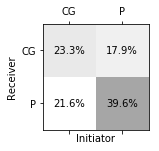

In [222]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.matshow(recip_probs, cmap=plt.cm.gray_r, vmax=0.8)
for from_p, to_p in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    s = f"{recip_probs[from_p, to_p]*100:4>.1f}%"
    ax.text(from_p, to_p, s, verticalalignment='center', horizontalalignment='center')

plt.xticks([0, 1], ['CG', 'P'])
plt.yticks([0, 1], ['CG', 'P'])
plt.xlabel("Initiator")
plt.ylabel("Receiver")

plt.tight_layout(pad=0.1)
plt.margins(0,0)
plt.savefig(os.path.join(figures_dir, 'recip_role_probs.pdf'), dpi=180, pad_inches=0)

plt.show()

In [223]:
import re
for line in res.summary2().as_latex().split("\n"):
    toks = line.split("&")
    if len(toks) < 4:
        print(line)
    else:
        new_toks = [f"{float(tok):.3f}" if re.match(r'^-?\d+(?:\.\d+)?$', tok.strip()) else tok for tok in toks[:3]]
        print(" & ".join(new_toks))

\begin{table}
\caption{Results: Logit}
\begin{center}
\begin{tabular}{llll}
\hline
Model:               &  Logit             &  Pseudo R-squared: 
Dependent Variable:  &  is\_reciprocated  &  AIC:              
Date:                &  2020-06-01 10:53  &  BIC:              
No. Observations:    & 725062.000 &  Log-Likelihood:   
Df Model:            & 11.000 &  LL-Null:          
Df Residuals:        & 725050.000 &  LLR p-value:      
Converged:           & 1.000 &  Scale:            
No. Iterations:      & 6.000 &                    
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                                                  &   Coef.   &  Std.Err. 
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                                         & -2.337 & 0.008
from\_author\_type[T.mixed]                                       & -0.091 & 0.016
from\_author\_type[T.p]                                      

### Reciprocal timeline analysis

Explored by the type of interaction.

In [91]:
reciprocation_times = []
original_int_types = []
reciprocating_int_types = []

initiations_dict = {}
initiations_type_dict = {}
for from_user_id, to_user_id, created_at, int_type in tqdm(zip(initiations_df.from_user_id, initiations_df.to_user_id, initiations_df.created_at, initiations_df.int_type), total=len(initiations_df)):
    key = (from_user_id, to_user_id)
    assert key not in initiations_dict
    inverse_key = (to_user_id, from_user_id)
    if inverse_key in initiations_dict:
        original_created_at = initiations_dict[inverse_key]
        if original_created_at < subset_start_timestamp:
            continue
        time_between_initiations = created_at - original_created_at
        reciprocation_times.append(time_between_initiations)
        assert time_between_initiations >= 0
        original_int_type = initiations_type_dict[inverse_key]
        
        original_int_types.append(original_int_type)
        reciprocating_int_types.append(int_type)
        
    initiations_dict[key] = created_at
    initiations_type_dict[key] = int_type


100%|██████████| 1144492/1144492 [00:02<00:00, 483627.31it/s]


6.91 months is the mean reciprocation time.
2.86 months is the mean guestbook reciprocation time. (10.47% of reciprocations)
7.09 months is the mean comments reciprocation time. (50.57% of reciprocations)
7.75 months is the mean amps reciprocation time. (38.95% of reciprocations)
3.07 months is the median reciprocation time.
0.74 months is the median guestbook reciprocation time. (10.47% of reciprocations)
3.55 months is the median comments reciprocation time. (50.57% of reciprocations)
3.50 months is the median amps reciprocation time. (38.95% of reciprocations)


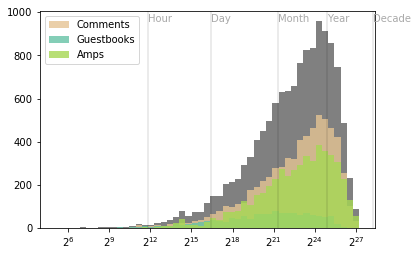

In [96]:
# amount of time between the original and the reciprocating interaction, broken down by the reciprocating interaction type
num_bins=50
base = 2
x = np.array(reciprocation_times) / 1000
original_int_types = np.array(original_int_types)
reciprocating_int_types = np.array(reciprocating_int_types)

logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='gray')
plt.xscale('log', nonposx='clip', basex=base)
ax = plt.gca()

cmap = matplotlib.cm.Set2
ax.hist(x[reciprocating_int_types == 'comment'], bins=logbins, color=cmap(0.8), alpha=0.8, label='Comments')
ax.hist(x[reciprocating_int_types == 'guestbook'], bins=logbins, color=cmap(0), alpha=0.8, label='Guestbooks')
ax.hist(x[reciprocating_int_types == 'amps'], bins=logbins, color=cmap(0.5), alpha=0.8, label='Amps')

print(f"{np.mean(x / (60 * 60 * 24 * 30)):.2f} months is the mean reciprocation time.")
print(f"{np.mean(x[reciprocating_int_types == 'guestbook'] / (60 * 60 * 24 * 30)):.2f} months is the mean guestbook reciprocation time. ({len(x[reciprocating_int_types == 'guestbook']) / len(x) * 100:.2f}% of reciprocations)")
print(f"{np.mean(x[reciprocating_int_types == 'comment'] / (60 * 60 * 24 * 30)):.2f} months is the mean comments reciprocation time. ({len(x[reciprocating_int_types == 'comment']) / len(x) * 100:.2f}% of reciprocations)")
print(f"{np.mean(x[reciprocating_int_types == 'amps'] / (60 * 60 * 24 * 30)):.2f} months is the mean amps reciprocation time. ({len(x[reciprocating_int_types == 'amps']) / len(x) * 100:.2f}% of reciprocations)")
print(f"{np.median(x / (60 * 60 * 24 * 30)):.2f} months is the median reciprocation time.")
print(f"{np.median(x[reciprocating_int_types == 'guestbook'] / (60 * 60 * 24 * 30)):.2f} months is the median guestbook reciprocation time. ({len(x[reciprocating_int_types == 'guestbook']) / len(x) * 100:.2f}% of reciprocations)")
print(f"{np.median(x[reciprocating_int_types == 'comment'] / (60 * 60 * 24 * 30)):.2f} months is the median comments reciprocation time. ({len(x[reciprocating_int_types == 'comment']) / len(x) * 100:.2f}% of reciprocations)")
print(f"{np.median(x[reciprocating_int_types == 'amps'] / (60 * 60 * 24 * 30)):.2f} months is the median amps reciprocation time. ({len(x[reciprocating_int_types == 'amps']) / len(x) * 100:.2f}% of reciprocations)")

      
plt.legend()

# add semantically interpretable time moments
#ax.axvline(60, color='black', alpha=0.1)
ax.axvline(60 * 60, color='black', alpha=0.1)
ax.axvline(60 * 60 * 24, color='black', alpha=0.1)
ax.axvline(60 * 60 * 24 * 30, color='black', alpha=0.1)
ax.axvline(60 * 60 * 24 * 365, color='black', alpha=0.1)
ax.axvline(60 * 60 * 24 * 365 * 10, color='black', alpha=0.1)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.95))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
#ax.text(60, text_y, 'Minute', color='darkgray')
ax.text(60 * 60, text_y, 'Hour', color='darkgray')
ax.text(60 * 60 * 24, text_y, 'Day', color='darkgray')
ax.text(60 * 60 * 24 * 30, text_y, 'Month', color='darkgray')
ax.text(60 * 60 * 24 * 365, text_y, 'Year', color='darkgray')
ax.text(60 * 60 * 24 * 365 * 10, text_y, 'Decade', color='darkgray')

plt.show()

6.91 months is the mean reciprocation time.
7.72 months is the mean reciprocation time to guestbooks.
6.70 months is the mean reciprocation time to comments.
6.76 months is the mean reciprocation time to amps.
3.07 months is the median reciprocation time.
3.47 months is the median reciprocation time to guestbooks.
3.07 months is the median reciprocation time to comments.
2.93 months is the median reciprocation time to amps.


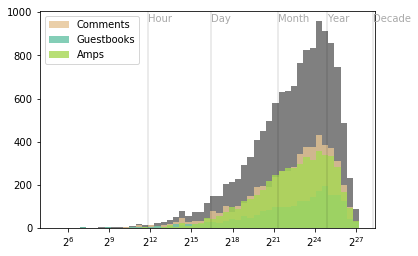

In [97]:
# the same plot as above, but broken down by the ORIGINATING interaction type
num_bins=50
base = 2
x = np.array(reciprocation_times) / 1000
original_int_types = np.array(original_int_types)
reciprocating_int_types = np.array(reciprocating_int_types)

logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, color='gray')
plt.xscale('log', nonposx='clip', basex=base)
ax = plt.gca()

cmap = matplotlib.cm.Set2
ax.hist(x[original_int_types == 'comment'], bins=logbins, color=cmap(0.8), alpha=0.8, label='Comments')
ax.hist(x[original_int_types == 'guestbook'], bins=logbins, color=cmap(0), alpha=0.8, label='Guestbooks')
ax.hist(x[original_int_types == 'amps'], bins=logbins, color=cmap(0.5), alpha=0.8, label='Amps')

print(f"{np.mean(x / (60 * 60 * 24 * 30)):.2f} months is the mean reciprocation time.")
print(f"{np.mean(x[original_int_types == 'guestbook'] / (60 * 60 * 24 * 30)):.2f} months is the mean reciprocation time to guestbooks.")
print(f"{np.mean(x[original_int_types == 'comment'] / (60 * 60 * 24 * 30)):.2f} months is the mean reciprocation time to comments.")
print(f"{np.mean(x[original_int_types == 'amps'] / (60 * 60 * 24 * 30)):.2f} months is the mean reciprocation time to amps.")
print(f"{np.median(x / (60 * 60 * 24 * 30)):.2f} months is the median reciprocation time.")
print(f"{np.median(x[original_int_types == 'guestbook'] / (60 * 60 * 24 * 30)):.2f} months is the median reciprocation time to guestbooks.")
print(f"{np.median(x[original_int_types == 'comment'] / (60 * 60 * 24 * 30)):.2f} months is the median reciprocation time to comments.")
print(f"{np.median(x[original_int_types == 'amps'] / (60 * 60 * 24 * 30)):.2f} months is the median reciprocation time to amps.")

plt.legend()

# add semantically interpretable time moments
#ax.axvline(60, color='black', alpha=0.1)
ax.axvline(60 * 60, color='black', alpha=0.1)
ax.axvline(60 * 60 * 24, color='black', alpha=0.1)
ax.axvline(60 * 60 * 24 * 30, color='black', alpha=0.1)
ax.axvline(60 * 60 * 24 * 365, color='black', alpha=0.1)
ax.axvline(60 * 60 * 24 * 365 * 10, color='black', alpha=0.1)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.95))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
#ax.text(60, text_y, 'Minute', color='darkgray')
ax.text(60 * 60, text_y, 'Hour', color='darkgray')
ax.text(60 * 60 * 24, text_y, 'Day', color='darkgray')
ax.text(60 * 60 * 24 * 30, text_y, 'Month', color='darkgray')
ax.text(60 * 60 * 24 * 365, text_y, 'Year', color='darkgray')
ax.text(60 * 60 * 24 * 365 * 10, text_y, 'Decade', color='darkgray')

plt.show()

In [94]:
# it seems like comments and guestbooks are more likely to be reciprocated or to be the reciprocating interaction type
# amps are common, but not likely to start reciprocated relationships
# this could be quantified more specifically if needed or desired
Counter(zip(original_int_types, reciprocating_int_types)).most_common()

[(('comment', 'comment'), 3220),
 (('amps', 'amps'), 2287),
 (('amps', 'comment'), 2194),
 (('comment', 'amps'), 1885),
 (('guestbook', 'comment'), 1037),
 (('guestbook', 'amps'), 797),
 (('guestbook', 'guestbook'), 466),
 (('amps', 'guestbook'), 448),
 (('comment', 'guestbook'), 422)]

#### Print final notebook processing time

In [98]:
total_processing_time = datetime.now() - start_time
print(f"Total processing time: {str(total_processing_time)}")

Total processing time: 6:03:45.766699
